<a href="https://colab.research.google.com/github/EternalSorrrow/bak/blob/master/ra2_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!ls 'drive/My Drive/Work/ML/RA2'
#!mkdir 'drive/My Drive/Work/ML/RA2/ra2'
#!unzip -P RAchallenge2 'drive/My Drive/Work/ML/RA2/training.zip' -d 'drive/My Drive/Work/ML/RA2/ra2'
#!mkdir 'drive/My Drive/Work/ML/RA2/ra2/temp_set'

!ls 'drive/My Drive/Work/ML/RA2/ra2/train' | head

training.csv
UAB001-LF.jpg
UAB001-LH.jpg
UAB001-RF.jpg
UAB001-RH.jpg
UAB002-LF.jpg
UAB002-LH.jpg
UAB002-RF.jpg
UAB002-RH.jpg
UAB003-LF.jpg


In [0]:
#@title Paths definition

train_set_path = 'drive/My Drive/Work/ML/RA2/ra2/train/'
temp_set_path = 'drive/My Drive/Work/ML/RA2/ra2/temp_set/'

In [4]:
#@title Select subsample of images

import os
import numpy as np

items_to_select = []
items_num = 100

for path in os.listdir(train_set_path):
  if 'LF' in path or 'RF' in path:
    items_to_select.append(path)

items_to_select = np.random.choice(items_to_select, items_num, replace = False)
items_to_select

array(['UAB596-LF.jpg', 'UAB659-LF.jpg', 'UAB654-LF.jpg', 'UAB086-LF.jpg',
       'UAB079-LF.jpg', 'UAB461-LF.jpg', 'UAB399-LF.jpg', 'UAB496-RF.jpg',
       'UAB318-LF.jpg', 'UAB488-RF.jpg', 'UAB200-RF.jpg', 'UAB659-RF.jpg',
       'UAB166-RF.jpg', 'UAB522-RF.jpg', 'UAB524-RF.jpg', 'UAB280-LF.jpg',
       'UAB067-RF.jpg', 'UAB428-LF.jpg', 'UAB013-RF.jpg', 'UAB177-RF.jpg',
       'UAB720-LF.jpg', 'UAB139-RF.jpg', 'UAB576-LF.jpg', 'UAB703-LF.jpg',
       'UAB706-LF.jpg', 'UAB497-LF.jpg', 'UAB394-RF.jpg', 'UAB477-LF.jpg',
       'UAB329-LF.jpg', 'UAB499-LF.jpg', 'UAB628-LF.jpg', 'UAB653-LF.jpg',
       'UAB052-LF.jpg', 'UAB532-RF.jpg', 'UAB379-RF.jpg', 'UAB396-LF.jpg',
       'UAB151-LF.jpg', 'UAB122-LF.jpg', 'UAB360-LF.jpg', 'UAB109-RF.jpg',
       'UAB006-RF.jpg', 'UAB126-RF.jpg', 'UAB563-RF.jpg', 'UAB140-RF.jpg',
       'UAB706-RF.jpg', 'UAB264-LF.jpg', 'UAB123-RF.jpg', 'UAB720-RF.jpg',
       'UAB463-RF.jpg', 'UAB024-RF.jpg', 'UAB108-LF.jpg', 'UAB085-LF.jpg',
       'UAB628-RF.jpg', '

In [5]:
#@title Temp set files count

import shutil

#for item in items_to_select:
#  shutil.copy(train_set_path + item, temp_set_path)

len(os.listdir(temp_set_path))

102

In [0]:
#@title Load annotation file

import json
import cv2

annotations = None

with open(temp_set_path + 'ann.json') as json_file:
  annotations = json.load(json_file)

In [0]:
#@title Load images and parse annotations

def load_images(ann_file):
  files = dict()
  for item in ann_file['images']:
    f = cv2.imread(train_set_path + item['file_name'])
    i = item['id']

    name = item['file_name']
    
    files[i] = (name, f)
  return files

def load_annotations(ann_file):
  a = dict()
  for ann in ann_file['annotations']:
    a_id, im_id, segmentation, cat = int(ann['id']), int(ann['image_id']), ann['segmentation'], int(ann['category_id'])
    segmentation = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)]
    
    if im_id not in a.keys():
      a[im_id] = dict()

    a[im_id][cat] = segmentation
  return a

def load_categories(ann_file):
  cats = dict()
  for item in ann_file['categories']:
    cat_id, name = int(item['id']), item['name']
    cats[cat_id] = name
  return cats

imgs = load_images(annotations)
anns = load_annotations(annotations)
categories = load_categories(annotations)
#annotations['annotations'][:1]

80 annotation sets found


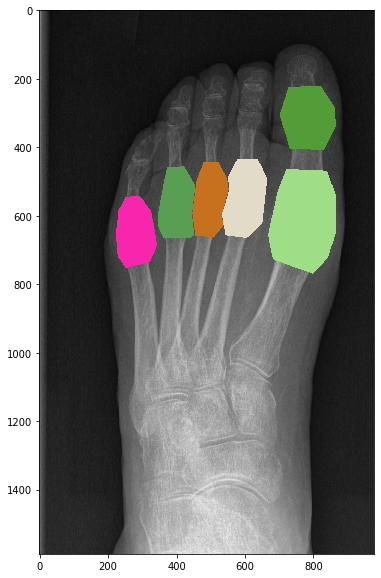

In [8]:
#@title Example image

import matplotlib.pyplot as plt

print(len(anns), 'annotation sets found')
ex_id = np.random.choice(range(len(anns)))

img = imgs[ex_id][1].copy()
ans = anns[ex_id].values()

randcol = lambda : (np.random.randint(255), np.random.randint(255), np.random.randint(255)) 

for poly in ans:
  poly = np.array(poly, dtype=np.int32)
  cv2.fillPoly(img, [poly], randcol())

plt.figure(figsize=(10, 10))
plt.imshow(img)

In [0]:
#@title Create data set

def get_dataset(images, annotations, categories):
  cat_num = len(categories.keys()) + 1
  
  data = []
  gt = []

  for key in annotations.keys():
    fname, image = images[key]
    gt_map = np.zeros(
        shape=(image.shape[0], image.shape[1], cat_num),
        dtype = np.uint8
    )
    
    none_map = np.ones(  #0th channel is the "None" channel, 1 by default
        shape=(image.shape[0], image.shape[1]),
        dtype=np.uint8
    )

    for i in range(cat_num - 1):
      category = i + 1
      canvas = np.zeros(
          shape=(image.shape[0], image.shape[1]),
          dtype=np.uint8
      )
      poly = [ np.array(annotations[key][category]) ]

      cv2.fillPoly(canvas, poly, (1))
      cv2.fillPoly(none_map, poly, (0))

      gt_map[:, :, category] = canvas
    
    gt_map[:, :, 0] = none_map
    if 'LF' in fname:
      image = np.flip(image, axis=1)
      gt_map = np.flip(gt_map, axis=1)

    data.append(image)
    gt.append(gt_map)

  return data, gt

X, Y = get_dataset(imgs, anns, categories)

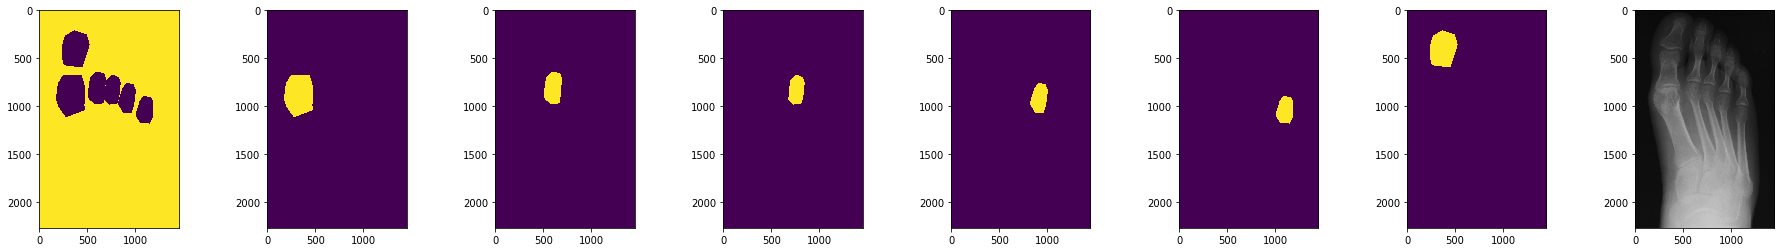

In [10]:
#@title One-hot encoding

ex_id = np.random.choice(range(len(anns)))

scale = 4
ncols = len(categories.keys()) + 2
fig, ax = plt.subplots(
    figsize=(scale * ncols, scale),
    ncols=ncols,
    nrows=1
)

for i, axis in enumerate(ax.flat):
  if i == ncols-1:
    axis.imshow(X[ex_id])
  else:
    axis.imshow(Y[ex_id][:, :, i])
  
plt.show()

In [0]:
#@title Variables definition

input_shape = (512, 512, 3)
num_classes = 7

In [12]:
#@title UNet

import keras
from keras import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, ZeroPadding2D
from keras.layers import MaxPooling2D, AveragePooling2D, Dropout, SpatialDropout2D, concatenate
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2

def conv2d_block(input_tensor, n_filters, regularizer, kernel_size=3, batchnorm=True, use_bias=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same", kernel_regularizer=regularizer, use_bias=use_bias)(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same", kernel_regularizer=regularizer, use_bias=use_bias)(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def residual_block(input_tensor, n_filters, regularizer, kernel_size=3, batchnorm=True, use_bias=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same", kernel_regularizer=regularizer, use_bias=use_bias)(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same", kernel_regularizer=regularizer, use_bias=use_bias)(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True, pooling='max', regularizer=l2(1e-4), use_bias=True):
    # contracting path
    pooling = MaxPooling2D if pooling=='max' else AvgPooling2D

    c1 = conv2d_block(input_img, n_filters=n_filters*1, regularizer=regularizer, kernel_size=3, batchnorm=batchnorm, use_bias=use_bias)
    p1 = pooling((2, 2)) (c1)
    p1 = SpatialDropout2D(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, regularizer=regularizer, kernel_size=3, batchnorm=batchnorm, use_bias=use_bias)
    p2 = pooling((2, 2)) (c2)
    p2 = SpatialDropout2D(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, regularizer=regularizer, kernel_size=3, batchnorm=batchnorm, use_bias=use_bias)
    p3 = pooling((2, 2)) (c3)
    p3 = SpatialDropout2D(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, regularizer=regularizer, kernel_size=3, batchnorm=batchnorm, use_bias=use_bias)
    p4 = pooling(pool_size=(2, 2)) (c4)
    p4 = SpatialDropout2D(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, regularizer=regularizer, kernel_size=3, batchnorm=batchnorm, use_bias=use_bias)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=regularizer, use_bias=use_bias) (c5)
    u6 = concatenate([u6, c4])
    u6 = SpatialDropout2D(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, regularizer=regularizer, kernel_size=3, batchnorm=batchnorm, use_bias=use_bias)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=regularizer, use_bias=use_bias) (c6)
    u7 = concatenate([u7, c3])
    u7 = SpatialDropout2D(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, regularizer=regularizer, kernel_size=3, batchnorm=batchnorm, use_bias=use_bias)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=regularizer, use_bias=use_bias) (c7)
    u8 = concatenate([u8, c2])
    u8 = SpatialDropout2D(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, regularizer=regularizer, kernel_size=3, batchnorm=batchnorm, use_bias=use_bias)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=regularizer, use_bias=use_bias) (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = SpatialDropout2D(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, regularizer=regularizer, kernel_size=3, batchnorm=batchnorm, use_bias=use_bias)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

Using TensorFlow backend.


In [0]:
#@title ResUNet

def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.025):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.05):
    x = SpatialDropout2D(dropout)(x)

    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

def ResUNet(inputs, dropout=0.05):
    f = [16, 32, 64, 128, 256]
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2, dropout=dropout * 0.5)
    e3 = residual_block(e2, f[2], strides=2, dropout=dropout)
    e4 = residual_block(e3, f[3], strides=2, dropout=dropout)
    e5 = residual_block(e4, f[4], strides=2, dropout=dropout)
    
    ## Bridge
    b0 = SpatialDropout2D(dropout)(e5)
    b1 = conv_block(b0, f[4], strides=1)
    b2 = conv_block(b1, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4], dropout=dropout)
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3], dropout=dropout)
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2], dropout=dropout)
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1], dropout=dropout)
    
    outputs = Conv2D(num_classes, 1, activation='softmax')(d4)
    model = Model(inputs, outputs)
    
    return model

In [0]:
#@title DenseUNet

from keras.layers import UpSampling2D

def dense_conv_block(x, growth_rate, name, use_bias, regularizer):
  x1 = BatchNormalization(name=name+'_bn')(x)
  x1 = Activation('relu', name=name+'_relu')(x1)
  x1 = Conv2D(growth_rate, (3,3), name=name+'_conv', padding='same',
              use_bias=use_bias, kernel_regularizer=regularizer)(x1)
  return concatenate([x, x1])

def dense_block(x, conv_blocks, growth_rate, name, use_bias, regularizer):
  for i in range(conv_blocks):
    block_name = name + '_' + str(i)
    x = dense_conv_block(x, growth_rate, name=block_name, use_bias=use_bias, regularizer=regularizer)
  return x

def transition_down(x):
  x = MaxPooling2D((2,2))(x)
  return x

def transition_up(x, name, reduction, use_bias, regularizer):
  x = BatchNormalization(name=name+'_bn')(x)
  x = Activation('relu')(x)
  x = Conv2D(int(K.int_shape(x)[3] * reduction), 1, name = name + '_1x1conv',
             use_bias=use_bias, kernel_regularizer=regularizer)(x)
  x = UpSampling2D((2, 2))(x)
  
  return x

def dense_stem(x, filters, name, use_bias, regularizer):
  x = Conv2D(filters, (3,3), padding='same', name=name+'_conv', 
             use_bias = use_bias, kernel_regularizer = regularizer)(x)
  x = BatchNormalization(name = name + '_bn')(x)
  x = Activation('relu')(x)
  return x
  
def reduction(x, reduction, name, use_bias, regularizer):
  x = BatchNormalization(name = name + '_bn')(x)
  x = Activation('relu')(x)
  x = Conv2D(int(K.int_shape(x)[3] * reduction), (1,1), name=name+'_1x1conv', 
             use_bias = use_bias, kernel_regularizer = regularizer)(x)
  return x
  

def DenseUNet(model_input, dropout=0.05, use_bias=True, regularizer=None):
  blocks = [4, 4, 4, 4, 4] #[12, 12, 12, 12, 12]
  growth_rate = [4, 8, 16, 32, 64]

  #Contracting path
  x = dense_stem(model_input, 16, 'stem', use_bias, regularizer)

  d1 = dense_block(x, blocks[0], growth_rate[0], 'dense1', use_bias, regularizer)
  p1 = transition_down(d1)
  p1 = SpatialDropout2D(dropout)(p1)

  d2 = dense_block(p1, blocks[1], growth_rate[1], 'dense2', use_bias, regularizer)
  p2 = transition_down(d2)
  p2 = SpatialDropout2D(dropout)(p2)

  d3 = dense_block(p2, blocks[2], growth_rate[2], 'dense3', use_bias, regularizer)
  p3 = transition_down(d3)
  p3 = SpatialDropout2D(dropout)(p3)

  d4 = dense_block(p3, blocks[3], growth_rate[3], 'dense4', use_bias, regularizer)
  p4 = transition_down(d4)
  p4 = SpatialDropout2D(dropout)(p4)

  d5 = dense_block(p4, blocks[4], growth_rate[4], 'dense5', use_bias, regularizer)
  d5 = SpatialDropout2D(dropout)(d5)

  #Expanding path
  u1 = transition_up(d5, 'up1', 0.5, use_bias, regularizer)
  c1 = concatenate([u1, d4])
  c1 = SpatialDropout2D(dropout)(c1)
  r1 = reduction(c1, 0.25, 'reduction1', use_bias, regularizer)
  d6 = dense_block(r1, blocks[3], growth_rate[3], 'dense6', use_bias, regularizer)

  u2 = transition_up(d6, 'up2', 0.5, use_bias, regularizer)
  c2 = concatenate([u2, d3])
  c2= SpatialDropout2D(dropout)(c2)
  r2 = reduction(c2, 0.25, 'reduction2', use_bias, regularizer)
  d7 = dense_block(r2, blocks[2], growth_rate[2], 'dense7', use_bias, regularizer)


  u3 = transition_up(d7, 'up3', 0.5, use_bias, regularizer)
  c3 = concatenate([u3, d2])
  c3 = SpatialDropout2D(dropout)(c3)
  r3 = reduction(c3, 0.25, 'reduction3', use_bias, regularizer)
  d8 = dense_block(r3, blocks[1], growth_rate[1], 'dense8', use_bias, regularizer)


  u4 = transition_up(d8, 'up4', 0.5, use_bias, regularizer)
  c4 = concatenate([u4, d1])
  c4 = SpatialDropout2D(dropout)(c4)
  r4 = reduction(c4, 0.25, 'reduction4', use_bias, regularizer)
  d9 = dense_block(r4, blocks[0], growth_rate[0], 'dense9', use_bias, regularizer)

  r5 = reduction(d9, 0.25, 'reduction5', use_bias, regularizer)
  c5 = concatenate([r5, x])
  d10 = dense_block(r4, blocks[0], growth_rate[0], 'dense10', use_bias, regularizer)

  outputs = Conv2D(num_classes, 1, activation='softmax', name='output')(d10)
  model = Model(model_input, outputs)
  
  return model


In [0]:
image_size = (512, 512)
train_size = 72

In [23]:
#@title Train/val split

def to_np(images_list, spatial_shape=None):
  y, x = None, None
  if spatial_shape == None:
    y, x = np.mean([ image.shape[0] for image in images_list ], dtype=np.uint32), np.mean([ image.shape[1] for image in images_list ], dtype=np.uint32)
  else:
    y, x = spatial_shape
  array = [ cv2.resize(image, (x, y)) for image in images_list]
  return np.array(array)

x = to_np(X, image_size)
y = to_np(Y, image_size)

train_indices = np.random.choice(range(x.shape[0]), train_size, replace=False)
val_indices = [ x for x in range(x.shape[0]) if x not in train_indices ]

x_train, y_train, x_val, y_val = x[train_indices], y[train_indices], x[val_indices], y[val_indices]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((72, 512, 512, 3), (72, 512, 512, 7), (8, 512, 512, 3), (8, 512, 512, 7))

In [0]:
#@title Data generators definition

from keras.preprocessing.image import ImageDataGenerator

def standardize(batch):
  return (batch - batch.mean(axis=(0,1,2), dtype=np.float32))/batch.std(axis=(0,1,2), dtype=np.float32)

train_datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    samplewise_center=True,
    samplewise_std_normalization=True,
    
    rotation_range=15,
    
    #horizontal_flip=True,
    #vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.05,
    
    brightness_range=(0.4, 0.6)
    #preprocessing_function=standardize
)

val_datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    samplewise_center=True,
    samplewise_std_normalization=True,
    #preprocessing_function=standardize
)

#train_datagen.fit(x_train)
#val_datagen.fit(x_val)

Displaying images normalized to [0, 1] with mean [1.2382786e-07 1.2382786e-07 1.2382786e-07] and std [0.9979001 0.9979001 0.9979001]


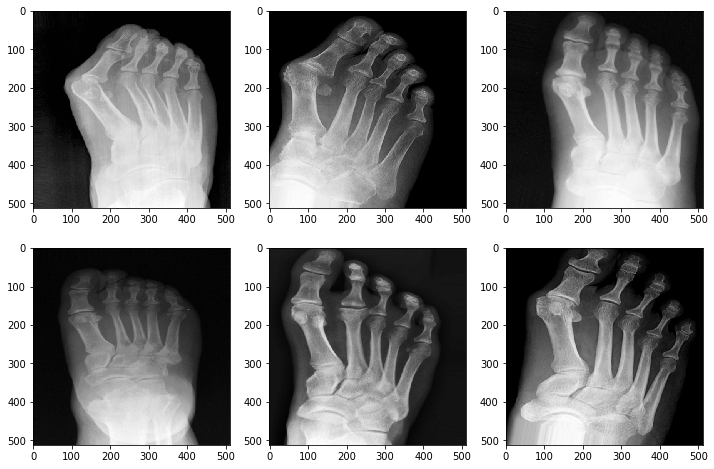

In [25]:
#@title Example generator output

def normalize_image(image):
  return (image - np.min(image))/(np.max(image) - np.min(image))

n_cols, n_rows = 3, 2

fig, ax = plt.subplots(figsize=(4 * n_cols, 4 * n_rows), ncols=n_cols, nrows=n_rows)

samples = train_datagen.flow(
    x_train, y_train, batch_size=n_cols * n_rows, shuffle=True
).next()

print('Displaying images normalized to [0, 1] with mean', samples[0].mean(axis=(0,1,2)), 'and std', samples[0].std(axis=(0,1,2)))

for index, axis in enumerate(ax.flat):
  sample = samples[0][index]
  axis.imshow(normalize_image(sample))
  
plt.show()

In [42]:
#@title Class weights computing

from sklearn.utils import class_weight

labels = np.argmax(y_train, axis=3).flat

class_weight = class_weight.compute_class_weight(
                'balanced',
                np.unique(labels),
                labels
              )

quadratic_class_weight = class_weight * class_weight
class_weight, quadratic_class_weight

(array([ 0.15868724,  4.62515123,  9.46256259, 11.96686573, 12.11717622,
        11.73918544,  7.99161308]),
 array([2.51816416e-02, 2.13920239e+01, 8.95400908e+01, 1.43205875e+02,
        1.46825959e+02, 1.37808475e+02, 6.38658796e+01]))

In [0]:
#@title Modular live loss plotter callback

#Modular live loss plotter for Keras models
#Allows to create custom layouts of per-batch or per-epoch plots for different metrics

#Monitor class defines a plot, which either may be batch or epoch-scoped, and may contain several graphs
#Batch monitor plots its values per batch, and refreshes itself on new epoch begin
#Epoch monitor plots its values per epoch, and performs no refresh
#All values/last N values displaying
#Log-scale/Linear scale displaying

#Plotter callback handles different Monitors and responds to the actual plotting
#Defines a grid where Monitors will be drawn, grid size, refresh rate in batches
#when the Monitors will be re-drawn in addition to per-epoch update
#Plotter can be silenced to disable plotting and only archivate per-epoch data

from IPython.display import clear_output
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class Monitor():
    def __init__(self, scope='epoch', monitors= [ 'loss' ], plot_last=-1, log_scale=False, precision=4):
        self.scope = scope.lower()
        self.monitors = [ monitor.lower() for monitor in monitors ]
        self.plot_last = max(0, plot_last)
        self.x = []
        self.ys = [ [] for monitor in monitors ]
        self.log_scale = log_scale
        self.precision = precision

    def reinit(self):
        self.x = []
        self.ys = [ [] for monitor in self.monitors ]

    def update(self, iteration, logs={}):
        self.x.append(iteration)
        
        for i, monitor in enumerate(self.monitors):
            if logs.get(monitor) is not None:
                self.ys[i].append(logs.get(monitor))
            else:
                pass #Action to execute when cannot get info for a certain monitor

    def plot(self, axis):
        x_data = self.x[ -self.plot_last : ]
        y_array = [ y_data[ -self.plot_last : ] for y_data in self.ys ]

        for i, y_data in enumerate(y_array):
            label = self.monitors[i] + '_' + self.scope #Compose graph name
            if self.log_scale:
                axis.set_yscale('log') #Set up scale
                
            if len(x_data) == len(y_data): #If data are coherent, plot them
                axis.plot(x_data, y_data, label=label)

                if self.precision > 0 and len(y_data) > 0: #If there's a last point plotted, print its value
                    text = str(round(y_data[-1],  self.precision))
                    axis.text(x_data[-1], y_data[-1], text)
            else:
                continue
                
        label = {'batch' : 'Batches', 'epoch' : 'Epochs'} #Set up x-label
        axis.set_xlabel(label[self.scope])
        
        axis.legend()


class Plotter(Callback):
    def __init__(self, scale=5, n_cols=2, n_rows=1, monitors=[], refresh_rate=-1, silent=False):
        if (n_cols * n_rows < len(monitors)):
            raise ValueError('Grid is too small to fit all monitors!')

        self.n_cols = n_cols
        self.n_rows = n_rows
        self.scale = scale

        self.monitors = monitors

        self.batch_monitors, self.epoch_monitors = [], []

        for monitor in monitors:
            if monitor.scope == 'epoch':
                self.epoch_monitors.append(monitor)
            elif monitor.scope == 'batch':
                self.batch_monitors.append(monitor)

        self.refresh_rate = refresh_rate
        self.silent = False

    def on_train_begin(self, logs={}):
        pass

    def on_epoch_begin(self, epoch, logs={}):
        [ monitor.reinit() for monitor in self.batch_monitors ]

    def plot(self):
        clear_output(wait=True)

        figsize = ( self.scale * self.n_cols, self.scale * self.n_rows)
        fig, ax = plt.subplots(figsize=figsize, ncols=self.n_cols, nrows=self.n_rows)

        for index, axis in enumerate(ax.flat):
          if index < len(self.monitors):
              self.monitors[index].plot(axis)

        plt.show()

    def on_batch_end(self, batch, logs={}):
        [ monitor.update(batch, logs) for monitor in self.batch_monitors ]

        if self.silent or batch == 0 or self.refresh_rate <= 0 or batch % self.refresh_rate != 0:
            return

        self.plot()

    def on_epoch_end(self, epoch, logs={}):
        [ monitor.update(epoch, logs) for monitor in self.epoch_monitors ]

        if self.silent:
            return

        self.plot()

    def reinit(self):
      [ monitor.reinit() for monitor in self.monitors ]


In [0]:
#@title Losses and metrics

from keras import backend as K
from keras.losses import categorical_crossentropy

def dice(y_true, y_pred, epsilon=1e-6):
  y_true_flatten = K.flatten(K.round(y_true))
  y_pred_flatten = K.flatten(K.round(y_pred))

  return (2. * K.sum(y_true_flatten * y_pred_flatten)) /\
        (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + epsilon)


def soft_dice(y_true, y_pred, epsilon=1e-6):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)

  return (2. * K.sum(y_true_flatten * y_pred_flatten)) /\
        (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + epsilon)

def soft_jaccard(y_true, y_pred, epsilon=1e-6):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)

  return (K.sum(y_true_flatten * y_pred_flatten)) /\
        (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - K.sum(y_true_flatten * y_pred_flatten) + epsilon)

def cce_logdice(y_true, y_pred):
  return categorical_crossentropy(y_true, y_pred) - K.log(soft_dice(y_true, y_pred))

def dice_loss(y_true, y_pred):
  return 1-soft_dice(y_true, y_pred)

def mse(y_true, y_pred):
  return K.sum((y_true - y_pred) * (y_true - y_pred))/ K.sum(K.ones_like(y_true))

def fbeta_cce_loss(self, y_true, y_pred, beta = 2):

    beta_sq = beta ** 2
    tp_loss = K.sum(y_true * (1 - K.categorical_crossentropy(y_pred, y_true)), axis=-1)
    fp_loss = K.sum((1 - y_true) * K.categorical_crossentropy(y_pred, y_true), axis=-1)

    return - K.mean((1 + beta_sq) * tp_loss / ((beta_sq * K.sum(y_true, axis = -1)) + tp_loss + fp_loss))

In [45]:
#@title Model instantiation

from keras.optimizers import adam

input_img = Input(input_shape, name='model_input')

#model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True, regularizer=None, use_bias=True)
#model = ResUNet(input_img, dropout=0.05)
model = DenseUNet(input_img, dropout=0.05, regularizer=None)

model.compile(optimizer=adam(lr=0.001), loss=cce_logdice, metrics=['accuracy', dice, soft_dice, cce_logdice])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 512, 512, 16) 448         model_input[0][0]                
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 512, 512, 16) 64          stem_conv[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 512, 512, 16) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [0]:
#@title Define plotter monitors

monitors = [
    Monitor(scope='epoch', monitors = ['loss', 'val_loss'], plot_last=32),
    Monitor(scope='epoch', monitors = ['dice', 'val_dice'], plot_last=32),
    Monitor(scope='epoch', monitors = ['acc', 'val_acc'], plot_last=16),
    Monitor(scope='epoch', monitors = ['cce_logdice', 'val_cce_logdice'], plot_last=16),
]

plotter = Plotter(monitors=monitors, n_rows=1, n_cols=4, scale=6, refresh_rate=-1)

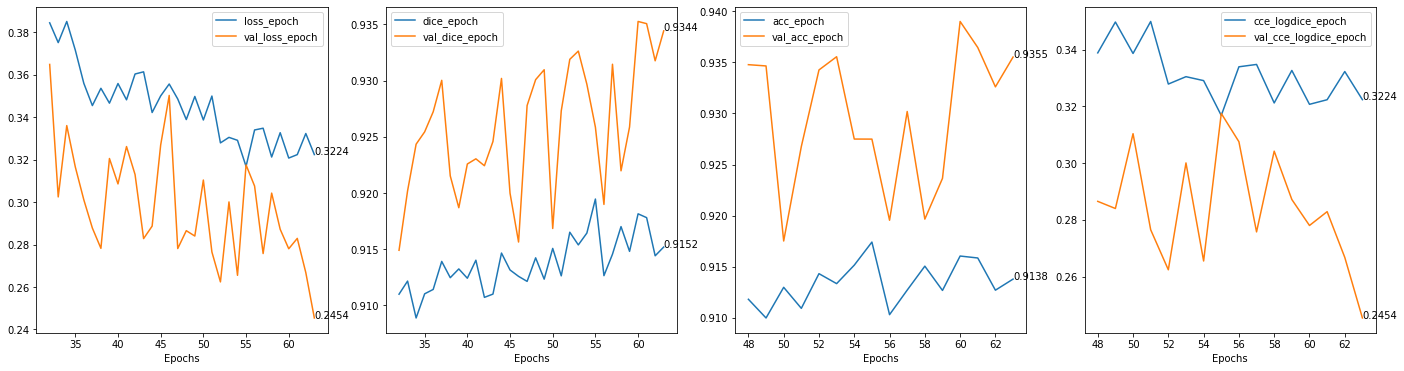

Epoch 65/300


In [0]:
batch_size = 4
val_batch_size = len(y_val)

epochs=300

callbacks = [ plotter ]

history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size, shuffle=True),
    validation_data = val_datagen.flow(x_val, y_val, val_batch_size, shuffle=False), 
    epochs=epochs, 
    callbacks=callbacks,
    #class_weight=class_weight,
    verbose=2
)

In [0]:
def decode_image(image, colors = None):
  ax = 3 if len(image.shape) == 4 else 2

  if not colors:
    colors = [randcol() for i in range(image.shape[ax])]

  if len(colors) != image.shape[ax]:
    raise ValueError('Cannot assign colors to depth channels')

  return np.argmax(image, axis=ax)


['loss', 'acc', 'dice', 'soft_dice', 'cce_logdice']


[0.012852401472628117,
 0.939424991607666,
 0.9369756579399109,
 0.8984939455986023,
 0.2797304391860962]

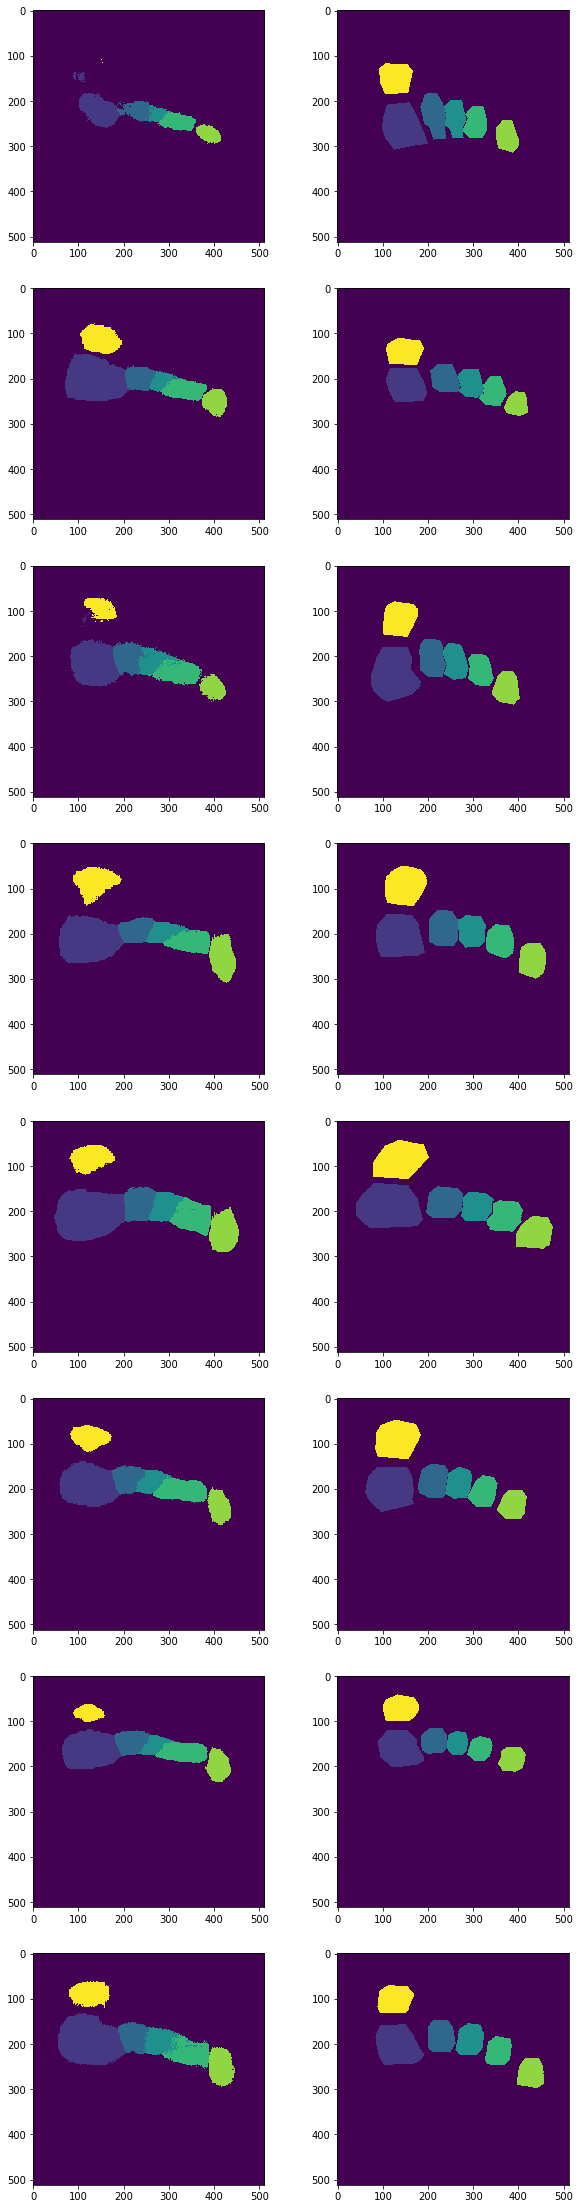

In [34]:
testgen = val_datagen.flow(x_val, y_val, batch_size = len(y_val), shuffle=False)

scale = 5

predict = model.predict_generator(testgen)
predict = decode_image(predict)

_, ax = plt.subplots(figsize=(scale * 2, len(y_val) * scale), ncols = 2, nrows=len(y_val))

for i in range(len(y_val)):
  ax[i, 0].imshow(predict[i])
  ax[i, 1].imshow(decode_image(y_val[i]))

print(model.metrics_names)
model.evaluate_generator(testgen)

In [35]:
a = np.unique(gt, return_counts=True)[1]
#a = (a - np.min(a))/np.max(a)
a.tolist()

NameError: ignored

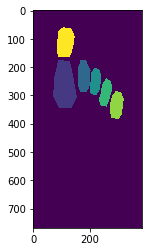

In [0]:
dec = decode_image(y_val[0])


plt.figure()
plt.imshow(dec)